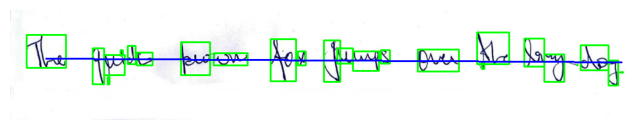

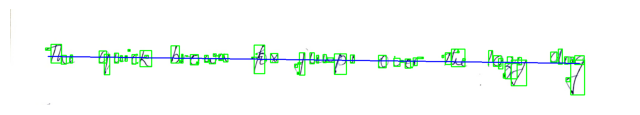

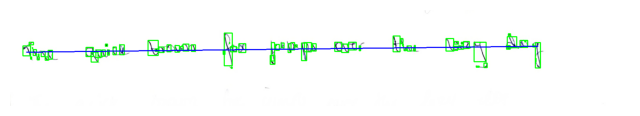

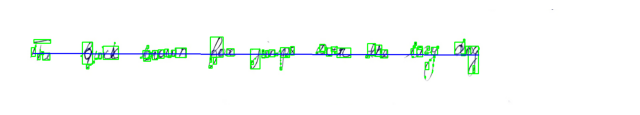

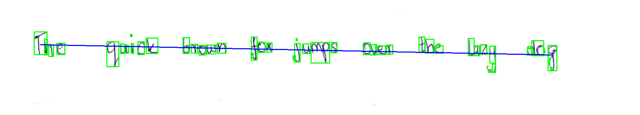

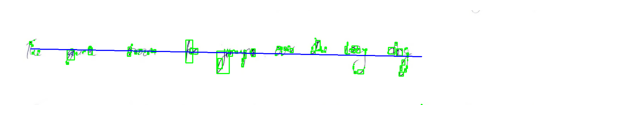

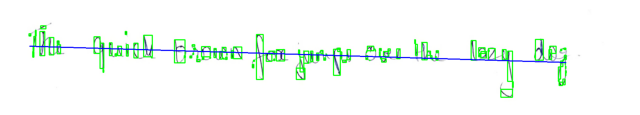

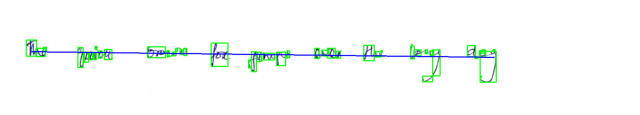

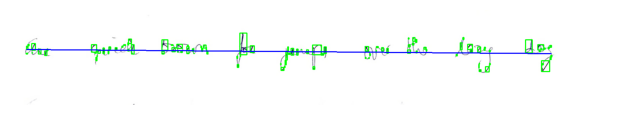

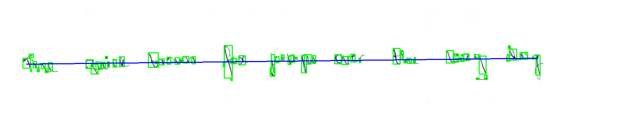

   img word_size     slant  baseline pen_pressure word_spacing
0    1       big  vertical  straight        heavy        close
1    2       avg     right     raise        light        close
2    3       avg      left     raise        light        close
3    4       avg  vertical  straight        light          far
4    5       big  vertical     raise        heavy          far
5    6     small     right     raise        light          far
6    7       avg     right     raise        light          far
7    8       avg     right     raise        light        close
8    9     small  vertical  straight        light          far
9   10       avg      left  straight        light        close


In [157]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

# Define a dictionary to store the categorical values for each image
categorical_values = {
    'img': [],
    'word_size': [],
    'slant': [],
    'baseline': [],
    'pen_pressure': [],
    'word_spacing': []
}

def analyze_images(image_paths):
    for idx, image_path in enumerate(image_paths, 1):
        # Load the image
        image = cv2.imread(image_path)

        # Reduce noise using Gaussian blur
        blurred = cv2.GaussianBlur(image, (5, 5), 0)

        # Convert the blurred image to grayscale
        gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

        # Apply adaptive thresholding to obtain a binary image
        _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

        # Find contours to detect spaces
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw rectangles around each word and calculate the edge distances
        distances = []
        center_points = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            distances.append(w)  # Add the width as the distance
            center_x = x + w // 2
            center_y = y + h // 2
            center_points.append((center_x, center_y))

        # Calculate the baseline (trendline) using numpy polyfit
        x_coords = [point[0] for point in center_points]
        y_coords = [point[1] for point in center_points]
        trendline = np.polyfit(x_coords, y_coords,1)  # Curve instead of a line

        # Draw the baseline on the image
        baseline_x = np.array([min(x_coords), max(x_coords)])
        baseline_y = np.polyval(trendline, baseline_x)
        baseline_color = (255, 0, 0)  # BGR format, so (255, 0, 0) is blue
        for i in range(len(baseline_x) - 1):
            start_point = (int(baseline_x[i]), int(baseline_y[i]))
            end_point = (int(baseline_x[i + 1]), int(baseline_y[i + 1]))
            cv2.line(image, start_point, end_point, baseline_color, 2)

        # Calculate the word spacing as the mean perpendicular distance between the centers of rectangles and the trendline
        word_spacing = 0
        for i in range(len(center_points)):
            x, y = center_points[i]
            distance = abs(y - (trendline[0] * x + trendline[1])) / np.sqrt(1 + trendline[0] ** 2)
            word_spacing += distance

        word_spacing /= len(center_points) if len(center_points) > 0 else 0



        # Determine the word size category based on the area that the rectangles cover
        areas = [cv2.contourArea(c) for c in contours]
        total_area = sum(areas)
        
        # Define the thresholds for small, average, and big word sizes
        small_threshold = 2000
        big_threshold = 4000
        
        if total_area <= small_threshold:
            word_size = 'small'
        elif small_threshold < total_area <= big_threshold:
            word_size = 'avg'
        else:
            word_size = 'big'
        
        # Determine the slant using PCA
        contour_points = np.vstack([c.reshape(-1, 2) for c in contours])
        centroid = np.mean(contour_points, axis=0)

        # Calculate the differences between the points and the centroid
        diffs = contour_points - centroid

        # Calculate the covariance matrix
        covariance_matrix = np.cov(diffs, rowvar=False)

        # Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

        # Get the index of the maximum eigenvalue
        max_eigenvalue_index = np.argmax(eigenvalues)

        # Get the corresponding eigenvector and calculate the slant in degrees
        max_eigenvector = eigenvectors[:, max_eigenvalue_index]
        slant_radians = np.arctan2(max_eigenvector[1], max_eigenvector[0])
        slant_degrees = np.degrees(slant_radians)


        if 0.8 < slant_degrees <= 135:
            slant = 'right'
        elif -135 <= slant_degrees < -0.001:
            slant = 'left'
        else:
            slant = 'vertical'
        

        # Calculate the baseline category based on trendline behavior
        baseline_deviation = np.std(np.diff(y_coords))

        if baseline_deviation < 10:
            baseline = 'straight'
        elif baseline_deviation > 15:
            baseline = 'down'
        elif baseline_deviation > 10 and baseline_deviation < 15:
            baseline = 'raise'
        else:
            baseline = 'erratic'

        # Determine the pen pressure category
        pen_pressure = 'heavy' if max(distances) > 50 else 'light'

        # Add values to the dictionary
        categorical_values['img'].append(idx)
        categorical_values['word_size'].append(word_size)
        categorical_values['slant'].append(slant)
        categorical_values['baseline'].append(baseline)
        categorical_values['pen_pressure'].append(pen_pressure)
        categorical_values['word_spacing'].append('close' if word_spacing < 12 else 'far')

        # Display the image with rectangles
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 6))
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()

    # Display the categorical values as a DataFrame
    df = pd.DataFrame(categorical_values)
    print(df)
    return df

# Example usage of the function
base_path = 'D:/NMIMS UNI/3rd Year/FOML/project/FOML_Project/img ('
num_images = 10
image_paths = [f"{base_path}{i}).jpg" for i in range(1, num_images + 1)]
df = analyze_images(image_paths)
